# Census Data Analysis Primer

This notebook will introduce you to the tools available to access, extract and visualise the **Scotland Census 2011 data**. Before starting your own analysis run the examples detailed below so that you get a good understanding of the  methods available. 

The notebook must first be moved into your project folder `census-UUN` (where `UUN` is your ID) before running any of the examples.  

Once you have run the examples in this notebook create a new notebook in your project folder named `census-UUN.ipynb` which will contain your own analysis and commentary. 

In [1]:
import census_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ensure descriptions are not truncated 
pd.set_option('display.max_colwidth', -1)

### Census Lookup table 

The file `lookuptable.pkl` contains the full list of table names and categories as a Pandas dataframe. Use the lookup table to explore which tables and categories are of interest in your study.

The lookup pickle file is available [here](https://www2.ph.ed.ac.uk/~awashbro/PDAML/lookup/lookuptable.pkl). Before running the cell below download the file and move it into your `lookup/` directory.  

In [6]:
# get lookup table from https://www2.ph.ed.ac.uk/~awashbro/PDAML/lookup/lookuptable.pkl and store locally before running
lookup = pd.read_pickle('../lookup/lookuptable.pkl') 

In [7]:
lookup.head()

TableCode  \
UniqueCatCode             
DC5202SC0001   DC5202SC   
DC5202SC0002   DC5202SC   
DC5202SC0003   DC5202SC   
DC5202SC0004   DC5202SC   
DC5202SC0005   DC5202SC   

                                                    TableDescription CatCode  \
UniqueCatCode                                                                  
DC5202SC0001   Highest level of qualification by ethnic group by age  0001     
DC5202SC0002   Highest level of qualification by ethnic group by age  0002     
DC5202SC0003   Highest level of qualification by ethnic group by age  0003     
DC5202SC0004   Highest level of qualification by ethnic group by age  0004     
DC5202SC0005   Highest level of qualification by ethnic group by age  0005     

                                                               CatDescription  
UniqueCatCode                                                                  
DC5202SC0001   All people aged 16 and over:_Total_All people aged 16 and over  
DC5202SC0002   All people aged 16 and over:_Total_White: Total                 
DC5202SC0003   All people aged 16 and over:_Total_White: Scottish              
DC5202SC0004   All people aged 16 and over:_Total_White: Other British         
DC5202SC0005   All people aged 16 and over:_Total_White: Irish

You can apply filters on the `lookup` dataframe to explore the different tables available and the associated categories in each table. You will need to reference the `UniqueCatCode` associated with each entry when extracting the data.

In [8]:
# filter on table code
lookup[lookup.TableCode == 'LC6109SC'].head()

TableCode            TableDescription CatCode  \
UniqueCatCode                                                 
LC6109SC0001   LC6109SC  Hours worked by sex by age  0001     
LC6109SC0002   LC6109SC  Hours worked by sex by age  0002     
LC6109SC0003   LC6109SC  Hours worked by sex by age  0003     
LC6109SC0004   LC6109SC  Hours worked by sex by age  0004     
LC6109SC0005   LC6109SC  Hours worked by sex by age  0005     

                                                                                     CatDescription  
UniqueCatCode                                                                                        
LC6109SC0001   All people aged 16 to 74 in employment:_Total_All people aged 16 to 74 in employment  
LC6109SC0002   All people aged 16 to 74 in employment:_Total_Part-time: Total                        
LC6109SC0003   All people aged 16 to 74 in employment:_Total_Part-time: 1 to 15 hours                
LC6109SC0004   All people aged 16 to 74 in employment:_Total_Part-time: 16 to 30 hours               
LC6109SC0005   All people aged 16 to 74 in employment:_Total_Full-time: Total

### Extracting Feature Data

Once you have selected some features of interest use `extractdata` to get the data supplying: 

- `requested`: The selected codes *as a dictionary* (using the table code as the key)
- `norm`: An *optional* **normalisation** mapping *as a dictionary* (see project guide for details) 
- `geo`: An *optional* geography type  


In the following example I chose the following:   
1. "Accommodation type by tenure - Households" / "All households_Owned: Owned outright"
2. "Dependent children by household type by age" / "All people aged 16 and over in households_Living in a couple household: Dependent children in household"
3. "Hours worked by sex by age" / "All people aged 16 to 74 in employment: Total_Full-time: Total"
  
Then I normalised the data with:
1. All households
2. Living in a couple household: Total
3. Total All people aged 16 to 74 in employment  

In [9]:
requested = { 'LC4427SC': ['0003'],
              'LC1112SC': ['0006'],
              'LC6109SC': ['0005']
            }
norm = { 'LC4427SC' : { '0003':'0001' },
         'LC1112SC' : { '0006':'0004' },
         'LC6109SC' : { '0005':'0001' }
       }

features = census_utils.extractdata(requested, norm)

All features are now normalised and contained in a dataframe ready for analysis:  

In [10]:
features.head()

LC4427SC0003  LC1112SC0006  LC6109SC0005
ONSCode                                            
S29000001  0.148478      0.258344      0.772363    
S29000002  0.246404      0.333205      0.807342    
S29000003  0.251430      0.351715      0.718368    
S29000004  0.096805      0.237463      0.747791    
S29000005  0.128045      0.256037      0.816162

In [11]:
features.shape

(1012, 3)

The default census **geography** is *LC Postcode Sector*. You can change this if you wish by applying a new geography type (`geo`) to `extractdata`. Unless you have a specific study in mind I would recommend sticking to the default. 

In [12]:
# Example using different geography
# geo = "Scottish Parliamentary Constituency"
# requested = { 'LC4427SC': ['0003'],
#               'LC1112SC': ['0006'],
#               'LC6109SC': ['0005']
#             }
# norm = { 'LC4427SC' : { '0003':'0001' },
#          'LC1112SC' : { '0006':'0004' },
#          'LC6109SC' : { '0005':'0001' }
#        }
# features = extractdata(requested, norm, geo)

### Choropleth Maps

Some of the trends of your chosen features may be regional (i.e north vs south Scotland, city areas vs rural areas). You can show variations between areas on a map of Scotland with a colour palette allowing any regional variations. These are known as [choropleth maps](https://en.wikipedia.org/wiki/Choropleth_map). For this study `folium` was chosen as this allows zooming in and out to explore detail in built up areas as well as the use of Openstreetmap tiling to display place names underneath the shading. 

A utility function `genchoropleth` makes it simple for you to generate these maps or can call the `folium` method directly. Before running the cell below download the map file `LC.geojson` from [here](https://www2.ph.ed.ac.uk/~awashbro/PDAML/maps/LC.geojson) and move it into your `maps/` directory.  

In [13]:
# NOTE - before running make sure you have downloaded LC.geojson into your maps directory 
census_utils.genchoropleth(features, 'LC6109SC0005')

You can apply your own map customisations by passing `map` and `choropleth` arguments as a dictionary to `genchoropleth`. For a full list of options see the `folium.map` and `folium.Choropleth` docstrings and the [folium documentation](http://python-visualization.github.io/folium/docs-v0.5.0/modules.html).

In the example below I have changed the colour palette to *yellow-green*, added a legend name and positioned to map to centre on Edinburgh: 

In [ ]:
# customised map focus on Edinburgh
copts = { "fill_color" : "YlGn", "legend_name" : "Proportion of Household owners"}
mopts = { "location" : [55.95, -3.19], "zoom_start" : 11}
census_utils.genchoropleth(features, 'LC4427SC0003', mopts_custom=mopts, copts_custom=copts)

### Generating a classification target 

The majority of the data is unlabelled and is therefore more suited to a regression study (i.e predicting the *value* of the target for a given area). You can either perform a regression using appropriate machine learning methods or segment the target data into classes.

In this first example I will use the proportion of the population in each area considered in *very good* health as a target feature. This data is found in table LC3102SC with unique code LC3102SC0002. To generate a proportion I will normalise this against LC3102SC0001 (*all* people in the area).

**Tiers** are defined to segment the data into a set number of classes. In the example below I have defined 3 classes: 

- Class 1: below the 20% quantile 
- Class 2: between the 20% and 80% quantiles 
- Class 3: above the 80% quantile   

This information is then passed to the `genclfsingle` method.

In [14]:
# single feature classification 
feature = 'LC3102SC0002'
norm = 'LC3102SC0001' 
tiers = [0.2, 0.8]
outcome = census_utils.genclfsingle(feature, tiers, norm)

/opt/conda-pdaml/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


`genclfsingle` then returns a dataframe with the `Class` as a column:

In [15]:
outcome.head()

Class
ONSCode         
S29000001  3    
S29000002  3    
S29000003  2    
S29000004  2    
S29000005  3

You can see the distribution of the `Class` values using the `Series` `hist` method: 

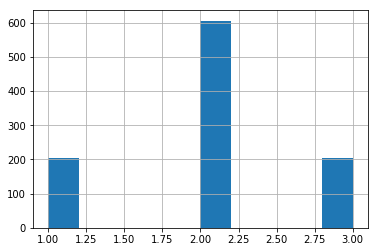

In [16]:
outcome.Class.hist()
plt.show()

You should see that the values are distributed as defined by the quantile value ranges

#### Combining multiple features

In some cases it may be more useful to define a target feature that is composed of multiple census data features. This is possible using the `genclfscore` method.

In the second example below I take the following values from table LC3102SC (General health by age): 

- LC3102SC0002: Very good health
- LC3102SC0003: Good health
- LC3102SC0004: Fair health
- LC3102SC0005: Bad health
- LC3102SC0006: Very bad health

The values for each are weighted for each area (*Very good* = 5 to *Very bad* = 1). A weighted average is then calculated for each area such that a metric is generated between 1-5 that captures the health of the population in a given area.

In [23]:
# multi-feature classifier 
requested = { 'LC3102SC': ['0002', '0003', '0004', '0005', '0006'] }
weights = { 'LC3102SC0002' : 5, 
           'LC3102SC0003' : 4,
           'LC3102SC0004' : 3,
           'LC3102SC0005' : 2,
           'LC3102SC0006' : 1 }
tiers = [0.2, 0.4, 0.6, 0.8]
outcome = census_utils.genclfscore(requested, weights, tiers)

`genclfscore` then returns a dataframe with the `Score` and `Class` as columns

In [24]:
outcome.head()

Score  Class
ONSCode                   
S29000001  4.442207  5    
S29000002  4.486076  5    
S29000003  4.285078  3    
S29000004  4.430728  5    
S29000005  4.532379  5

You can see the distribution of both `Score` and `Class` using the `Series` `hist` method: 

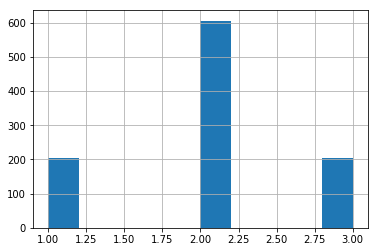

In [19]:
outcome.Class.hist()
plt.show()

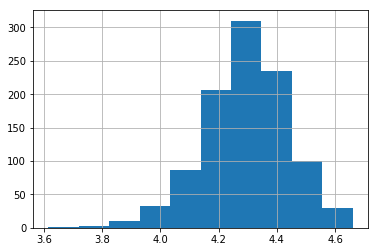

In [20]:
outcome.Score.hist()
plt.show()

Finally lets visualise the health score and health score class using `genchoropleth`:

In [21]:
census_utils.genchoropleth(outcome, 'Score')

In [22]:
census_utils.genchoropleth(outcome, 'Class')

A naive study shows that Aberdeenshire is a very healthy place to live and that you should live on the west side of Edinburgh! If this was the basis for your study you would then look to explain the result by considering the factors that contribute to (and predict) general health within an area. You would then use selected features to try and predict health by using a chosen machine learning technique. 